In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
DATA_PATH = r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data"
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [3]:
df = pd.read_csv(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\datanews_dataset_pre_processed.csv", 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [4]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [5]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


In [6]:
y = df.label
X = df.drop('label', axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [8]:
X_train.shape

(30910, 4)

In [9]:
X_test.shape

(7728, 4)

In [10]:
le = LabelEncoder()

In [11]:
y_train_enc = le.fit_transform(y_train)


In [12]:
y_test_enc = le.transform(y_test)


In [14]:
y_test_enc

array([1, 0, 1, ..., 1, 1, 0])

In [15]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [16]:
def confustion_matrix_and_classification_report(estimator, X, y, labels, set_name):
    """
    Display a Classfication Report and Confusion Matrix for the given data.
    """

    predictions = estimator.predict(X)

    print(f'Classification Report for {set_name} Set')
    print(classification_report(y, predictions, target_names=labels))

    matrix = plot_confusion_matrix(estimator,
                                   X,
                                   y,
                                   display_labels = labels,
                                   cmap = plt.cm.Blues,
                                   xticks_rotation = 70,
                                   values_format = 'd')
    matrix.ax_.set_title(f'{set_name} Set Confustion Matrix, without Normalization')

    plt.show()

    matrix = plot_confusion_matrix(estimator,
                                   X,
                                   y,
                                   display_labels = labels,
                                   cmap = plt.cm.Blues,
                                   xticks_rotation = 70,
                                   normalize = 'true')
    matrix.ax_.set_title(f'{set_name} Set Confustion Matrix, with Normalization')

    plt.show()

In [17]:
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc]

In [18]:
def remove_stopwords(doc):
    """Remove the stopwords from the input document"""
    stop_words = stopwords.words('english')
    return [token for token in doc if ((token not in stop_words) and (token.lower() not in stop_words))]

In [19]:
def lowercase_tokens(doc):
    """lowercase all letters in doc"""
    return [token.lower() for token in doc]

In [20]:
def lowercase_and_remove_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = stopwords.words('english')
    return [token.lower() for token in doc if token.lower() not in stop_words]

In [21]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, stopwords, max_df=1.0, ngram_range = (1, 1)):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           stop_words = stopwords,
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),  
    ('classifier', MultinomialNB()),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    fake_class_prob_sorted = pipeline['classifier'].feature_log_prob_[0, :].argsort()
    true_class_prob_sorted = pipeline['classifier'].feature_log_prob_[1, :].argsort()
    
    print('fake ', np.take(pipeline['bow'].get_feature_names(), fake_class_prob_sorted[::-1][:25]))
    print('')
    print('true ', np.take(pipeline['bow'].get_feature_names(), true_class_prob_sorted[::-1][:25]))

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.96      0.96      0.96     13957
        true       0.97      0.97      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.97      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



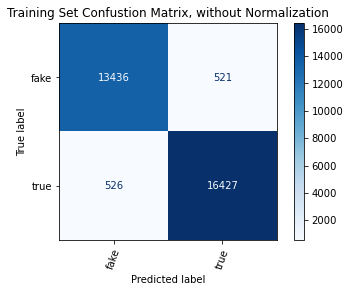

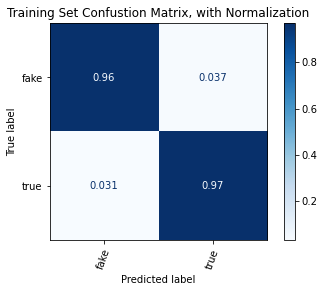

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.96      0.96      0.96      3490
        true       0.96      0.96      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



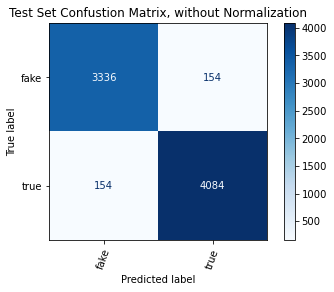

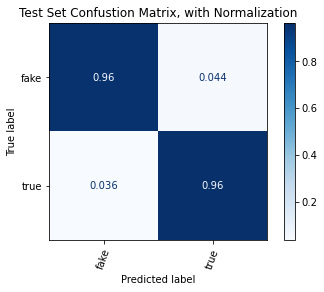

fake  ['trump' 'to' 'the' 'VIDEO' 'for' 'of' 'in' 'and' 'on' '!' 'is' 'video'
 'with' 'his' 'WATCH' 'he' 'about' 'obama' 'just' 'after' 'it' 'hillary'
 'at' 'by' 'from']

true  ['to' 'trump' 'in' 'U.S.' 'on' 'of' 'says' 'for' 'with' 'house' 'as'
 'after' 'over' 'north' 'russia' 'korea' 'at' 'white' 'new' 'from' 'not'
 'senate' 'china' 'will' 'court']


In [22]:
train_and_eval_model(X_train['clean_title_tokens'], X_test['clean_title_tokens'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, None)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.96     13957
        true       0.97      0.96      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



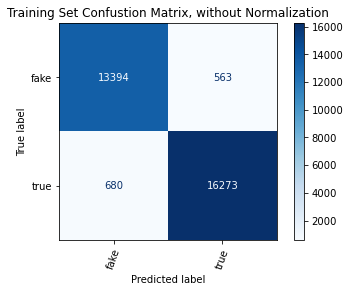

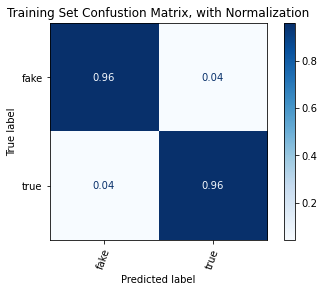

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.95      3490
        true       0.96      0.95      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



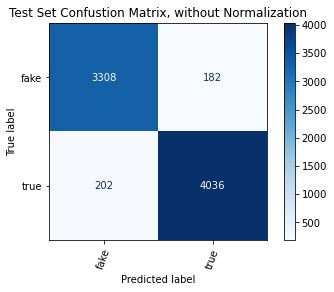

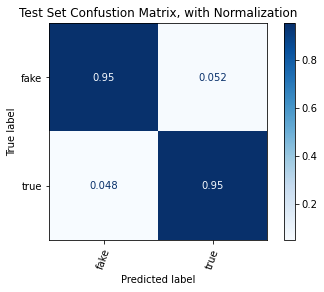

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'he' 'it' 'on' 'was'
 'with' 'his' 'this' 'as' 'be' 'not' 'are' 'they' 'have' 'i' 'by' 'has']

true  ['the' 'to' 'of' 'and' 'in' 'on' 'said' 'that' 'for' 'is' 'trump' 'with'
 'he' 'it' 'was' 'by' 'as' 'has' 'from' 'U.S.' 'his' 'not' 'have' 'be'
 'at']


In [23]:
train_and_eval_model(X_train['clean_text_tokens'], X_test['clean_text_tokens'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, None)

In [24]:
X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']

C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_5244/1922539037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['title_and_text'] = X_train['clean_title_tokens'] + X_train['clean_text_tokens']


In [25]:
X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']

C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_5244/2619957053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['title_and_text'] = X_test['clean_title_tokens'] + X_test['clean_text_tokens']


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96     13957
        true       0.97      0.96      0.97     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



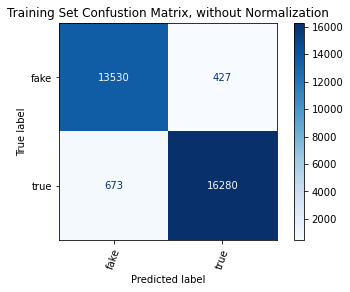

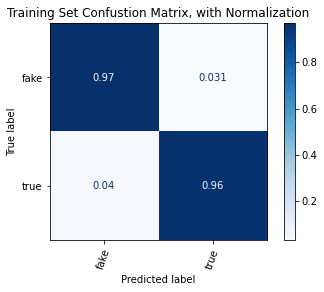

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95      3490
        true       0.96      0.95      0.96      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



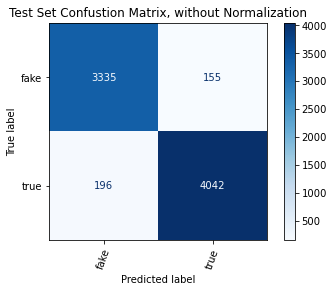

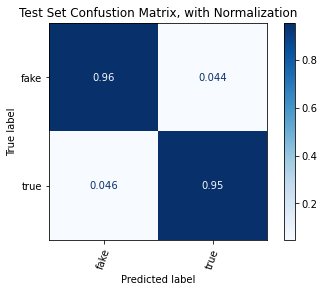

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'he' 'it' 'on' 'was'
 'with' 'his' 'this' 'as' 'be' 'are' 'not' 'they' 'have' 'i' 'by' 'has']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'trump' 'with' 'is'
 'he' 'it' 'as' 'by' 'was' 'has' 'U.S.' 'from' 'not' 'his' 'have' 'be'
 'at']


In [26]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, None)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96     13957
        true       0.97      0.96      0.97     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



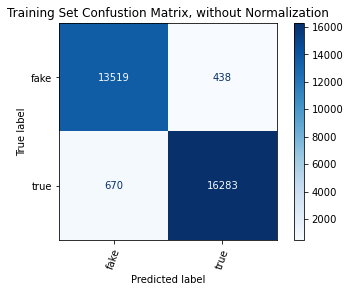

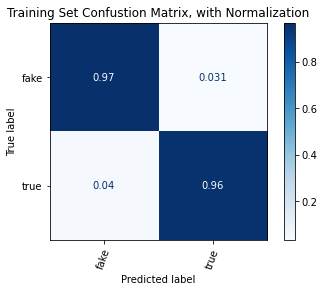

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.95      3490
        true       0.96      0.95      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



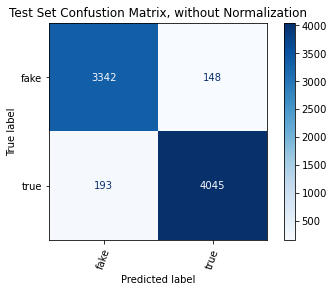

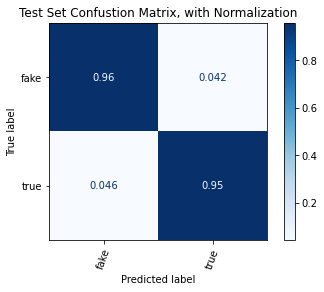

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'it' 'he' 'on' 'wa'
 'with' 'his' 'this' 'a' 'be' 'are' 'not' 'they' 'have' 'i' 'by' 'ha']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'it' 'trump' 'with'
 'is' 'he' 'a' 'by' 'wa' 'ha' 'U.S.' 'from' 'not' 'his' 'state' 'have'
 'be']


In [29]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, LemmaTokenizer(), None)

C:\Users\SHUBHAM KUMAR SINGH\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96     13957
        true       0.98      0.96      0.97     16953

    accuracy                           0.97     30910
   macro avg       0.96      0.97      0.97     30910
weighted avg       0.97      0.97      0.97     30910



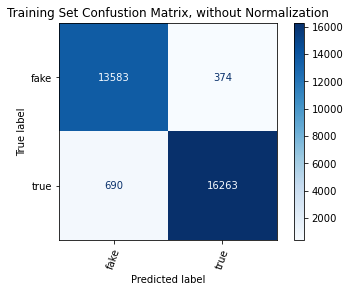

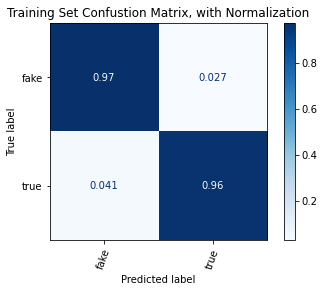

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95      3490
        true       0.97      0.95      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



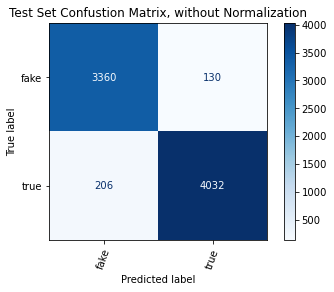

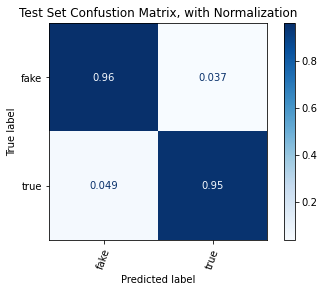

fake  ['trump' 'said' 'people' 'twitter-handle' 'president' 'would' 'one'
 'donald' '!' 'like' 'obama' 'clinton' 'also' 'even' 'new' 'white'
 'hillary' 'via' 'time' 'news' 'image' 'state' 'link' 'get' 'campaign']

true  ['said' 'trump' 'U.S.' 'would' 'president' 'state' 'government' 'house'
 'states' 'new' 'republican' 'also' 'united' 'people' 'told' 'could' 'one'
 'party' 'last' 'election' 'two' 'year' 'former' 'campaign' 'north']


In [30]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, passthrough, passthrough, stopwords.words('english'))

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.96      0.95      0.96     13957
        true       0.96      0.96      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



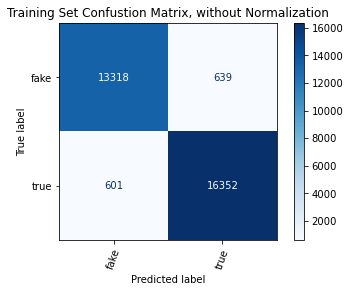

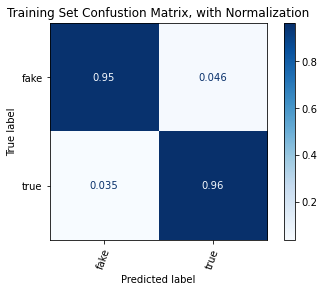

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.95      0.94      0.95      3490
        true       0.95      0.96      0.96      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



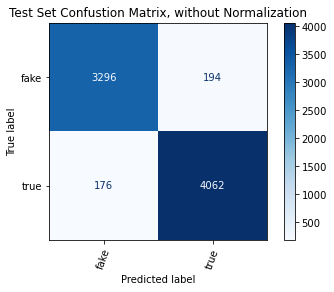

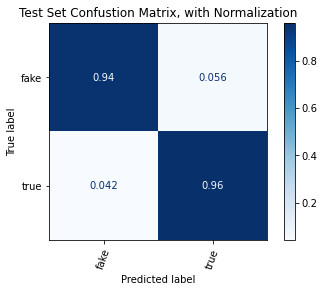

fake  ['trump' 'VIDEO' '!' 'video' 'WATCH' 'obama' 'hillary' 'GOP' 'donald'
 'president' 'TRUMP' 'white' 'clinton' 'BREAKING' 'new' 'news' 'black'
 'OBAMA' 'gets' 'TWEETS' 'says' 'one' 'republicans' 'HILLARY' 'republican']

true  ['trump' 'U.S.' 'says' 'house' 'north' 'russia' 'korea' 'white' 'new'
 'senate' 'china' 'court' 'bill' 'obama' 'republican' 'clinton' 'state'
 'tax' 'deal' 'vote' 'talks' 'election' 'EU' 'president' 'iran']


In [31]:
train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = passthrough, 
                     tokenizer = remove_stopwords, 
                     stopwords = None, 
                     max_df = 1.0)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.95     13957
        true       0.96      0.95      0.95     16953

    accuracy                           0.95     30910
   macro avg       0.95      0.95      0.95     30910
weighted avg       0.95      0.95      0.95     30910



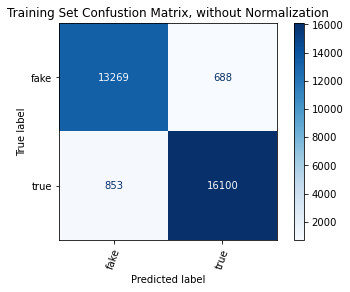

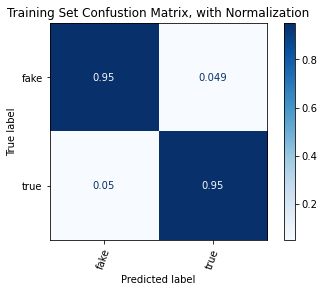

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      3490
        true       0.95      0.94      0.94      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



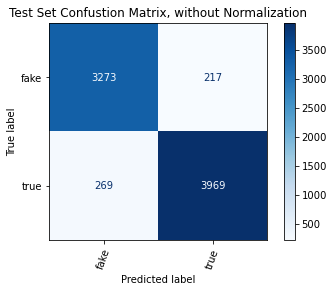

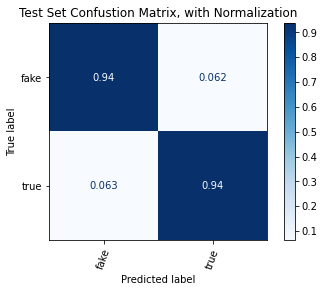

fake  ['trump' 'video' '!' 'obama' 'watch' 'hillary' 'president' 'clinton' 'gop'
 'donald' 'new' 'news' 'white' 'black' 'breaking' 'tweets' 'gets' 'one'
 'america' 'bill' 'media' 'says' 'muslim' 'house' 'republicans']

true  ['trump' 'u.s.' 'says' 'house' 'north' 'russia' 'korea' 'white' 'new'
 'senate' 'china' 'court' 'bill' 'obama' 'republican' 'clinton' 'state'
 'tax' 'deal' 'eu' 'vote' 'talks' 'election' 'president' 'iran']


In [32]:
train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = lowercase_tokens, 
                     tokenizer = remove_stopwords, 
                     stopwords = None, 
                     max_df = 1.0)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.95     13957
        true       0.96      0.95      0.96     16953

    accuracy                           0.95     30910
   macro avg       0.95      0.95      0.95     30910
weighted avg       0.95      0.95      0.95     30910



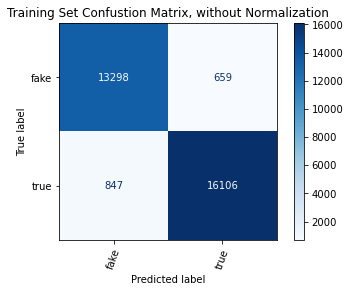

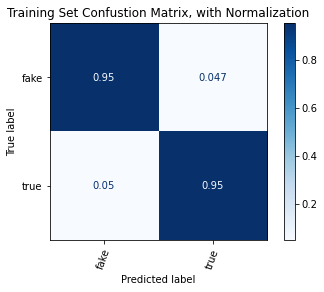

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      3490
        true       0.95      0.94      0.94      4238

    accuracy                           0.94      7728
   macro avg       0.94      0.94      0.94      7728
weighted avg       0.94      0.94      0.94      7728



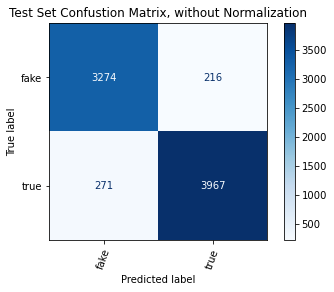

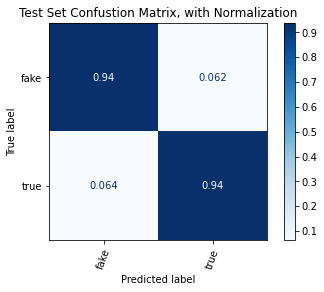

fake  ['trump' 'video' '!' 'obama' 'watch' 'hillary' 'republican' 'tweet'
 'president' 'clinton' 'get' 'gop' 'donald' 'donald trump' 'black' 'white'
 'new' 'news' 'say' 'breaking' 'make' 'woman' 'muslim' 'go' 'one']

true  ['trump' 'u.s.' 'say' 'house' 'republican' 'north' 'russia' 'korea'
 'white' 'new' 'white house' 'state' 'senate' 'china' 'court' 'bill'
 'north korea' 'obama' 'tax' 'clinton' 'vote' 'deal' 'talk' 'leader'
 'call']


In [33]:
train_and_eval_model(X_train = X_train['clean_title_tokens'], 
                     X_test = X_test['clean_title_tokens'], 
                     y_train_enc = y_train_enc, 
                     y_test_enc = y_test_enc, 
                     classes_ = le.classes_, 
                     preprocessor = lowercase_and_remove_stopwords, 
                     tokenizer = LemmaTokenizer(), 
                     stopwords = None, 
                     max_df = 1.0,
                     ngram_range = (1, 2))

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.95     13957
        true       0.97      0.96      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



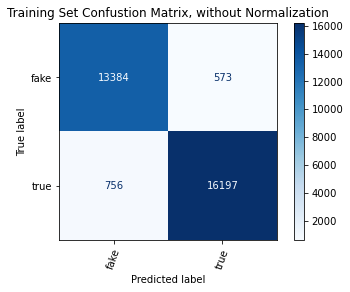

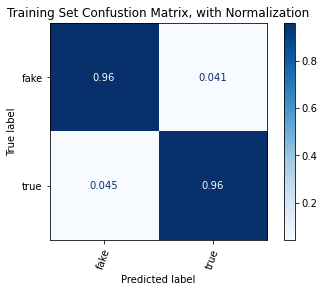

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.95      0.94      3490
        true       0.96      0.95      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



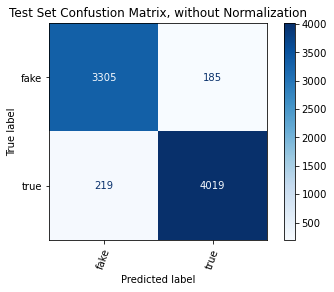

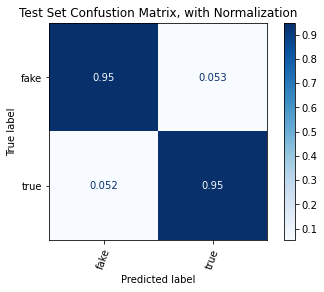

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'trump' 'it' 'he' 'on' 'wa'
 'with' 'his' 'this' 'a' 'be' 'not' 'are' 'they' 'have' 'by' 'i' 'ha']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'it' 'trump' 'with'
 'is' 'he' 'a' 'by' 'wa' 'ha' 'u.s.' 'from' 'not' 'his' 'state' 'have'
 'be']


In [34]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, lowercase_tokens, LemmaTokenizer(), None)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95     13957
        true       0.97      0.95      0.96     16953

    accuracy                           0.96     30910
   macro avg       0.96      0.96      0.96     30910
weighted avg       0.96      0.96      0.96     30910



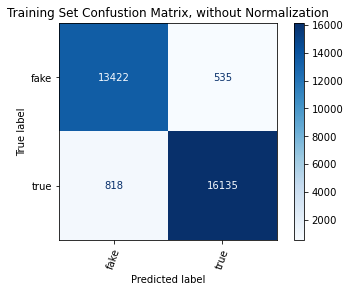

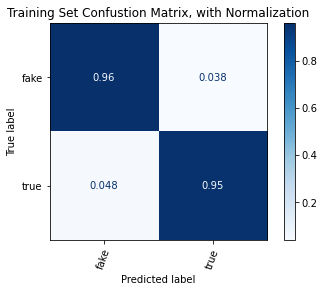

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.93      0.95      0.94      3490
        true       0.96      0.95      0.95      4238

    accuracy                           0.95      7728
   macro avg       0.95      0.95      0.95      7728
weighted avg       0.95      0.95      0.95      7728



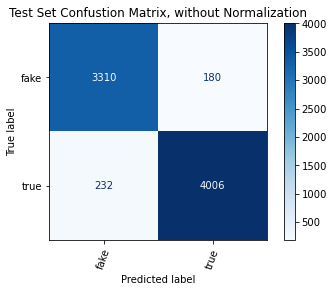

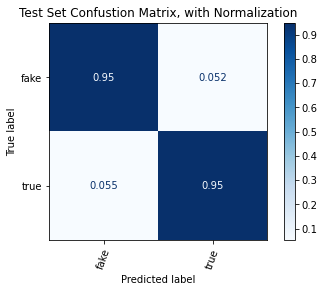

fake  ['trump' 'said' 'people' 'twitter-handle' 'president' 'one' 'would'
 'state' 'donald' 'republican' 'like' '!' 'obama' 'clinton' 'image' 'time'
 'video' 'say' 'american' 'also' 'even' 'year' 'white' 'new' 'hillary']

true  ['said' 'trump' 'u.s.' 'state' 'would' 'president' 'republican'
 'government' 'year' 'house' 'new' 'also' 'united' 'party' 'people'
 'official' 'election' 'told' 'country' 'could' 'one' 'say' 'washington'
 'last' 'two']


In [35]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, lowercase_and_remove_stopwords, LemmaTokenizer(), None)

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.97      0.98      0.97     13957
        true       0.98      0.97      0.98     16953

    accuracy                           0.98     30910
   macro avg       0.97      0.98      0.97     30910
weighted avg       0.98      0.98      0.98     30910



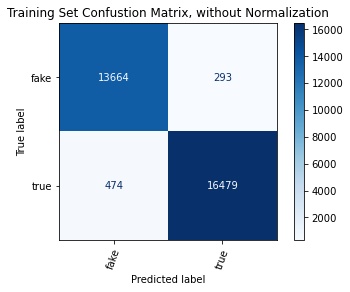

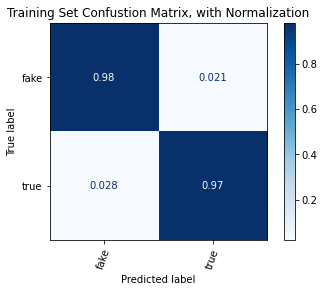

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.95      0.96      0.96      3490
        true       0.97      0.96      0.96      4238

    accuracy                           0.96      7728
   macro avg       0.96      0.96      0.96      7728
weighted avg       0.96      0.96      0.96      7728



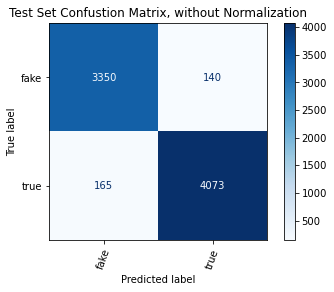

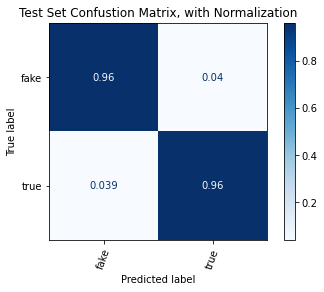

fake  ['trump' 'said' 'people' 'twitter-handle' 'president' 'one' 'would'
 'state' 'donald' 'republican' 'like' '!' 'obama' 'clinton' 'image' 'time'
 'video' 'say' 'donald trump' 'american' 'also' 'even' 'year' 'white'
 'new']

true  ['said' 'trump' 'u.s.' 'state' 'would' 'president' 'republican'
 'government' 'year' 'house' 'new' 'also' 'united' 'party' 'people'
 'official' 'election' 'told' 'country' 'could' 'one' 'say' 'washington'
 'last' 'united state']


In [36]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, 
                     lowercase_and_remove_stopwords, LemmaTokenizer(), None,
                     ngram_range = (1, 2))

In [37]:
def lowercase_and_only_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = stopwords.words('english')
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.87      0.80      0.84     13957
        true       0.85      0.91      0.88     16953

    accuracy                           0.86     30910
   macro avg       0.86      0.85      0.86     30910
weighted avg       0.86      0.86      0.86     30910



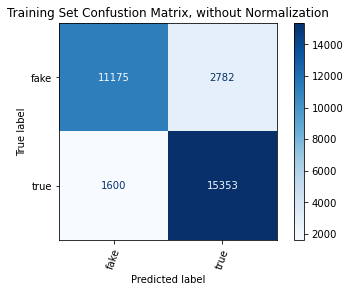

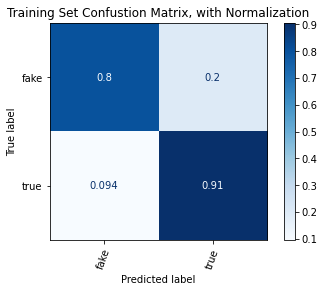

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.87      0.79      0.83      3490
        true       0.84      0.90      0.87      4238

    accuracy                           0.85      7728
   macro avg       0.86      0.85      0.85      7728
weighted avg       0.85      0.85      0.85      7728



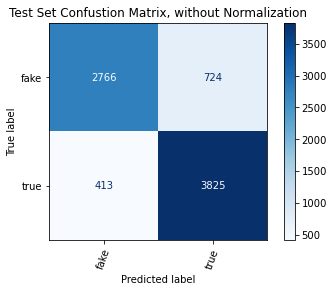

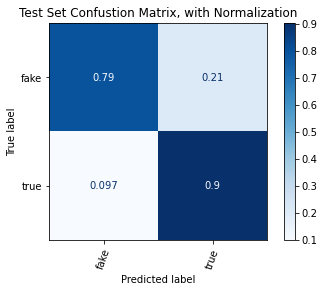

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'he' 'it' 'on' 'was' 'with'
 'his' 'this' 'as' 'be' 'not' 'are' 'they' 'have' 'by' 'i' 'you' 'has']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'that' 'for' 'with' 'is' 'he' 'it' 'as'
 'by' 'was' 'has' 'from' 'not' 'his' 'have' 'be' 'at' 'an' 'who' 'but']


In [38]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, 
                     lowercase_and_only_stopwords, passthrough, None)

In [44]:
# using expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\gist_stopwords.txt")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

In [45]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.93      0.88      0.91     13957
        true       0.90      0.95      0.93     16953

    accuracy                           0.92     30910
   macro avg       0.92      0.91      0.92     30910
weighted avg       0.92      0.92      0.92     30910



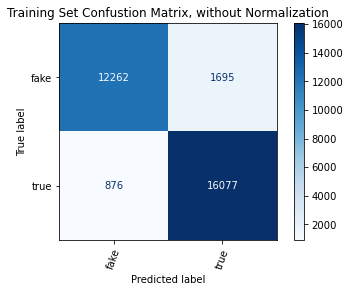

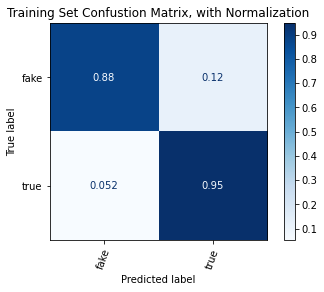

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.94      0.86      0.90      3490
        true       0.89      0.95      0.92      4238

    accuracy                           0.91      7728
   macro avg       0.91      0.91      0.91      7728
weighted avg       0.91      0.91      0.91      7728



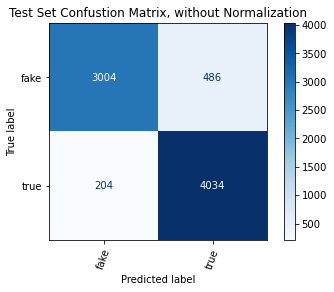

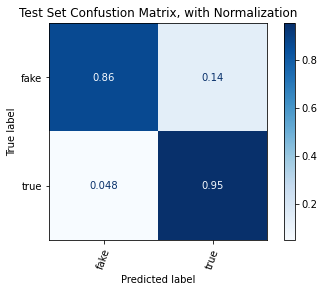

fake  ['the' 'to' 'of' 'and' 'in' 'that' 'is' 'for' 'he' 'it' 'on' 'was' 'with'
 'his' 'this' 'as' 'be' 'not' 'are' 'they' 'have' 'by' 'i' 'you' 'has']

true  ['the' 'to' 'of' 'in' 'and' 'on' 'said' 'that' 'for' 'with' 'is' 'he' 'it'
 'as' 'by' 'was' 'has' 'from' 'not' 'his' 'have' 'be' 'at' 'an' 'would']


In [46]:
train_and_eval_model(X_train['title_and_text'], X_test['title_and_text'], 
                     y_train_enc, y_test_enc, le.classes_, 
                     lowercase_and_only_expanded_stopwords, passthrough, None)